#Evidencia 2: Análisis de Aprendizaje Automático

Valeria Gisel Concha Valdovinos // A01657886

Melissa Dorantes Martínez // A01700634

María Alejandra Munévar Díaz // A01710026

Bruno Jasso Juárez // A01205116


## Documentación del Contexto y Datos

###Contexto del problema

Bepensa enfrenta un problema logístico centrado en la asignación eficiente de tractocamiones y remolques a rutas de alta demanda. La operación depende de garantizar que las unidades transporten el volumen adecuado de mercancía, minimizando fallas operativas, costos por incumplimiento y tiempos muertos derivados de unidades inactivas o mal asignadas.

En este contexto, el problema principal es optimizar la asignación de tractos según su nivel de riesgo, confiabilidad y capacidad, para maximizar el volumen transportado y asegurar la continuidad operativa en las rutas más críticas.

El objetivo general es desarrollar un modelo que prediga el comportamiento de demanda y permita decidir qué unidad asignar, reduciendo riesgos y mejorando la eficiencia del transporte.

### Evaluación de datos

Para esta evidencia utilizaremos la base de datos de viajes y de fallas, por lo que se realizará una investigación inicial de este reporte, misma que ya realizó en entregas pasadas.

##Viajes

In [1]:
# Carga de librerías
#!pip install missingno
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

In [2]:
viajes = pd.read_excel('Viajes.xlsx', sheet_name='ReporteListadoViajes (6)', header=0, usecols='A:AF')
viajes.head(5)

,Numero,Nombre Cliente,Folio,Ruta,Viaje,Viaje Docto,Sucursal,No. Viaje Cte,Fecha,Moneda,...,Nro Ope,Operador,Fecha Salida,Fecha Llegada,Peso Kgs,Peso Descarga Kgs,Diferencia,Documentos,UUID CP,Estatus de Viaje
0,1,EMBOTELLADORAS BEPENSA,105,BB PACABTUN/BB CIUDAD DEL CARMEN,LM/MID-000001659,CARTA PORTE CFDI 000000001659-CPMID,MERIDA/YUC001,6919,2025-01-01 00:00:00,PESOS,...,3798.0,GAMBOA FIERRO ALEJANDRO,2025-01-01 18:50:00,2025-01-02 05:17:00,54000.0,NaN,54000.0,NaN,NaN,TERMINADO
1,1,EMBOTELLADORAS BEPENSA,105,BB CIUDAD DEL CARMEN/BB PACABTUN,LM/MID-000001659,CARTA PORTE CFDI 000000001659-CPMID,MERIDA/YUC001,6919,2025-01-01 00:00:00,PESOS,...,3798.0,GAMBOA FIERRO ALEJANDRO,2025-01-02 09:30:00,2025-01-02 16:41:00,54000.0,NaN,54000.0,NaN,NaN,TERMINADO
2,1,EMBOTELLADORAS BEPENSA,199,BB PACABTUN/BB CAMPECHE OTE,LM/MID-000001661,CARTA PORTE CFDI 000000001661-CPMID,MERIDA/YUC001,5717,2025-01-01 00:00:00,PESOS,...,58816.0,CASTILLO DIAZ OMAR SALVADOR,2025-01-02 00:35:00,2025-01-02 03:02:00,54000.0,NaN,54000.0,NaN,NaN,TERMINADO
3,1,EMBOTELLADORAS BEPENSA,199,BB CAMPECHE OTE/BB PACABTUN,LM/MID-000001661,CARTA PORTE CFDI 000000001661-CPMID,MERIDA/YUC001,5717,2025-01-01 00:00:00,PESOS,...,58816.0,CASTILLO DIAZ OMAR SALVADOR,2025-01-02 03:50:00,2025-01-02 06:21:00,54000.0,NaN,54000.0,NaN,NaN,TERMINADO
4,1,EMBOTELLADORAS BEPENSA,204,BB PACABTUN/BB PLAYA DEL CARMEN,LM/MID-000001660,CARTA PORTE CFDI 000000001660-CPMID,MERIDA/YUC001,5716,2025-01-01 00:00:00,PESOS,...,1334.0,DIAZ ECHEVERRIA ALEJANDRO DE JESUS,2025-01-01 23:20:00,2025-01-02 09:30:00,54000.0,NaN,54000.0,NaN,NaN,TERMINADO


In [3]:
viajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108991 entries, 0 to 108990
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Numero             108991 non-null  int64         
 1   Nombre Cliente     108991 non-null  object        
 2   Folio              108991 non-null  int64         
 3   Ruta               108991 non-null  object        
 4   Viaje              108991 non-null  object        
 5   Viaje Docto        108991 non-null  object        
 6   Sucursal           108991 non-null  object        
 7   No. Viaje Cte      108991 non-null  object        
 8   Fecha              108991 non-null  object        
 9   Moneda             108991 non-null  object        
 10  SubTotal           108991 non-null  float64       
 11  IVA                108991 non-null  float64       
 12  Retención          108991 non-null  float64       
 13  Total              108991 non-null  float64 

In [4]:
viajes.isnull().sum()

Numero                    0
Nombre Cliente            0
Folio                     0
Ruta                      0
Viaje                     0
Viaje Docto               0
Sucursal                  0
No. Viaje Cte             0
Fecha                     0
Moneda                    0
SubTotal                  0
IVA                       0
Retención                 0
Total                     0
Factura                3693
Liquidación           35993
Fecha.1                3693
Fecha Vencimiento      3693
Tractocamión            897
Remolque 1             9312
Dolly                 94506
Remolque 2            66082
Nro Ope                 897
Operador                897
Fecha Salida          26129
Fecha Llegada         26166
Peso Kgs              30344
Peso Descarga Kgs    100226
Diferencia            39023
Documentos           108991
UUID CP              108991
Estatus de Viaje       2824
dtype: int64

Vemos que el reporte tiene muchos nulos, po lo tanto tomaremos acciones para el tratamiento de esos nulos tratando de no alterar el número de registros.

In [5]:
# Eliminamos las columnas de Documentos y UUID CP ya que no tenían registros
viajes.drop(['Documentos', 'UUID CP'], inplace=True, axis=1)

# Para las siguientes columnas, rellenamos los nulos con 'No utilizado'
viajes['Dolly'] = viajes['Dolly'].fillna('No utilizado')
viajes['Remolque 2'] = viajes['Remolque 2'].fillna('No utilizado')
viajes['Remolque 1'] = viajes['Remolque 1'].fillna('No utilizado')

#Para las columnas numéricas, rellenamos los nulos con 0
viajes['Liquidación'] = viajes['Liquidación'].fillna('0')
viajes['Peso Descarga Kgs'] = viajes['Peso Descarga Kgs'].fillna('0')
viajes['Diferencia'] = viajes['Diferencia'].fillna('0')
viajes['Peso Kgs'] = viajes['Peso Descarga Kgs'].fillna('0')

#Para las columnas de factura y estatus de viaje ocupamos unas variables que nos indicara que no había datos
viajes['Factura'] = viajes['Factura'].fillna('No hay factura')
viajes['Estatus de Viaje'] = viajes['Estatus de Viaje'].fillna('SIN STATUS')

In [6]:
#Para las columnas de fecha, convertimos las columnas en su formato correspondiente
viajes['Fecha'] = pd.to_datetime(viajes['Fecha'], errors='coerce')
viajes['Fecha.1'] = pd.to_datetime(viajes['Fecha.1'], errors='coerce')
viajes['Fecha Vencimiento'] = pd.to_datetime(viajes['Fecha Vencimiento'], errors='coerce')

#Para los nulos en Fecha.1 ocupamos la misma fecha que la primera columna de fecha
viajes['Fecha.1'] = viajes['Fecha.1'].fillna(viajes['Fecha'])

#Para la columna de fecha vencimiento, se ocumpo el último día del mes que tiene la primera columna de fecha
viajes['Fecha Vencimiento'] = viajes['Fecha Vencimiento'].fillna(
    viajes['Fecha'].dt.to_period('M').dt.to_timestamp('M')
)

In [7]:
#Por último, para las columnas de Fecha Salida y Fecha Llegada, los convertimos igual a formato de fecha y los nulos los llenamos con 0
viajes['Fecha Salida'] = pd.to_datetime(viajes['Fecha Salida'], errors='coerce')
viajes['Fecha Salida'] = viajes['Fecha Salida'].fillna(0)

viajes['Fecha Llegada'] = pd.to_datetime(viajes['Fecha Llegada'], errors='coerce')
viajes['Fecha Llegada'] = viajes['Fecha Llegada'].fillna(0)

<Axes: >

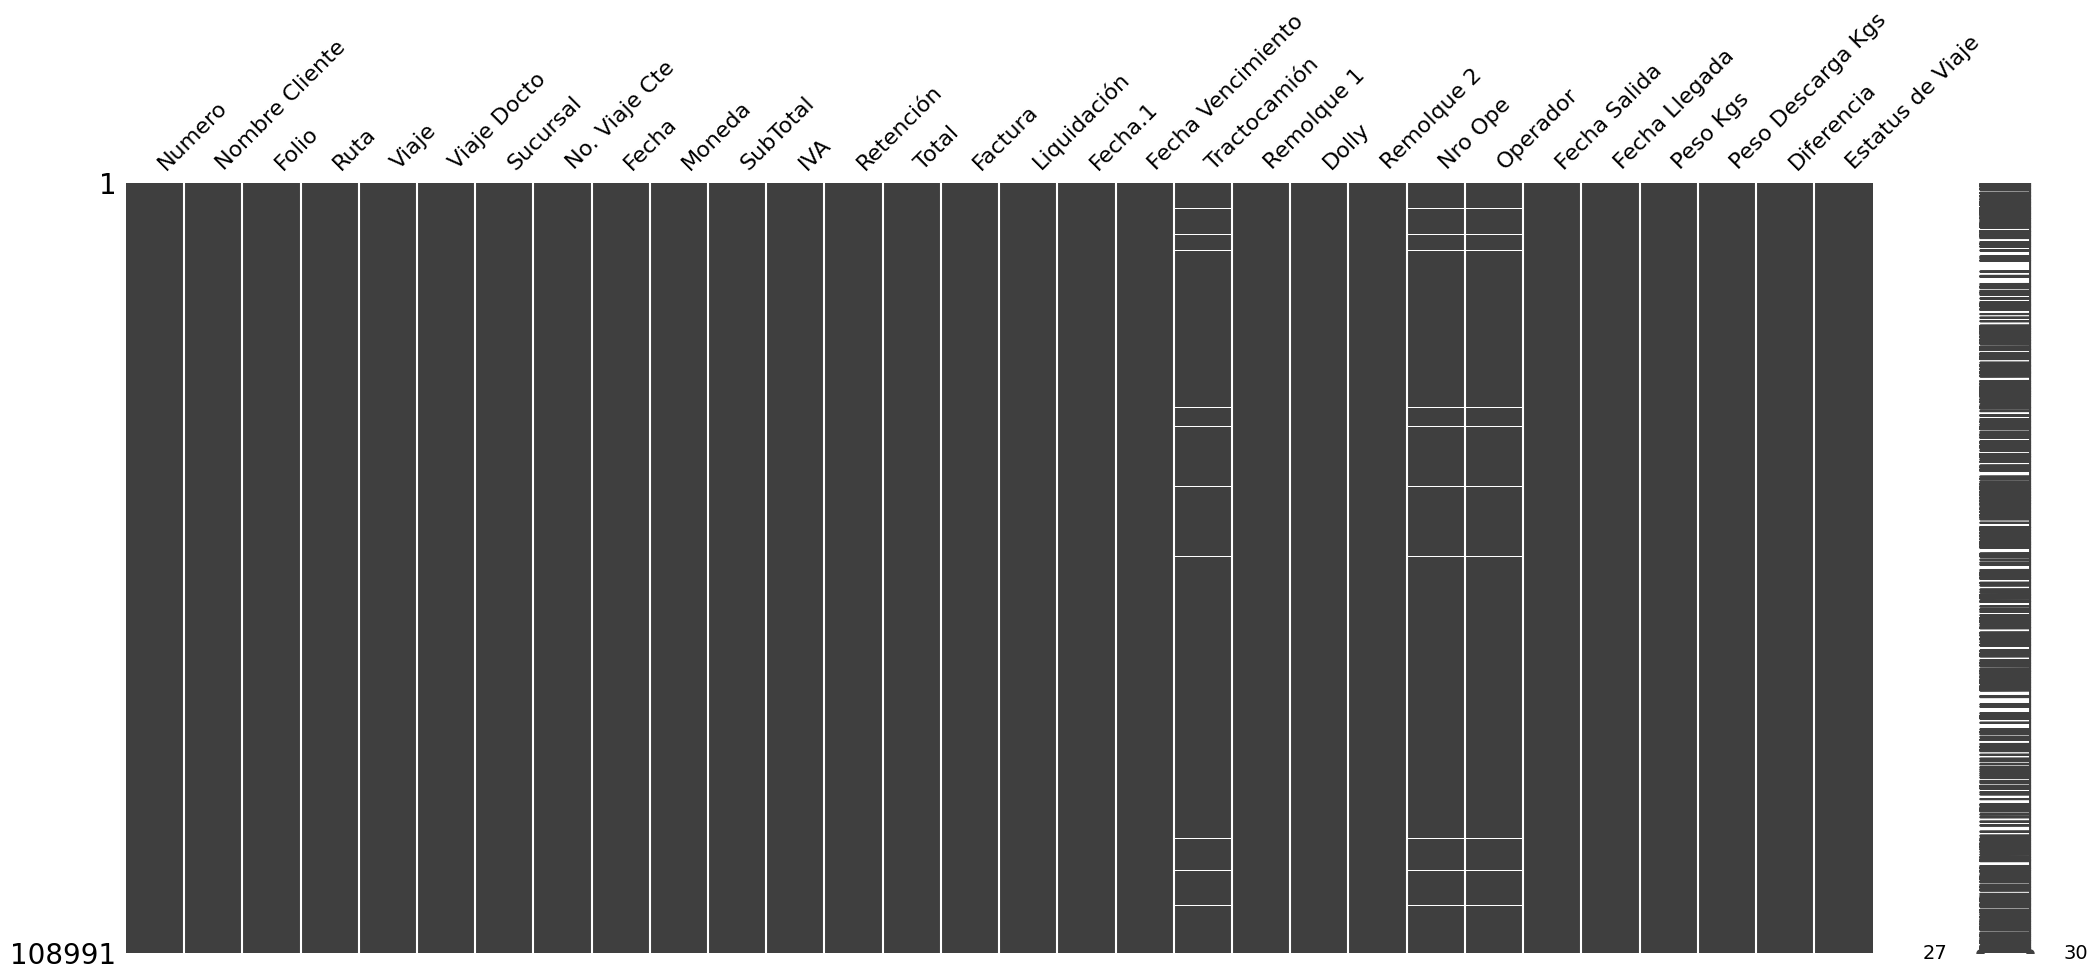

In [8]:
msno.matrix(viajes)

In [9]:
# Finalmente, las filas que tienen nulos en Tractocamión, son las mismas que tienen nulos en NroOpe y Operador, por lo que decidimos eliminar esas filas
viajes = viajes.dropna(subset=['Tractocamión'])

<Axes: >

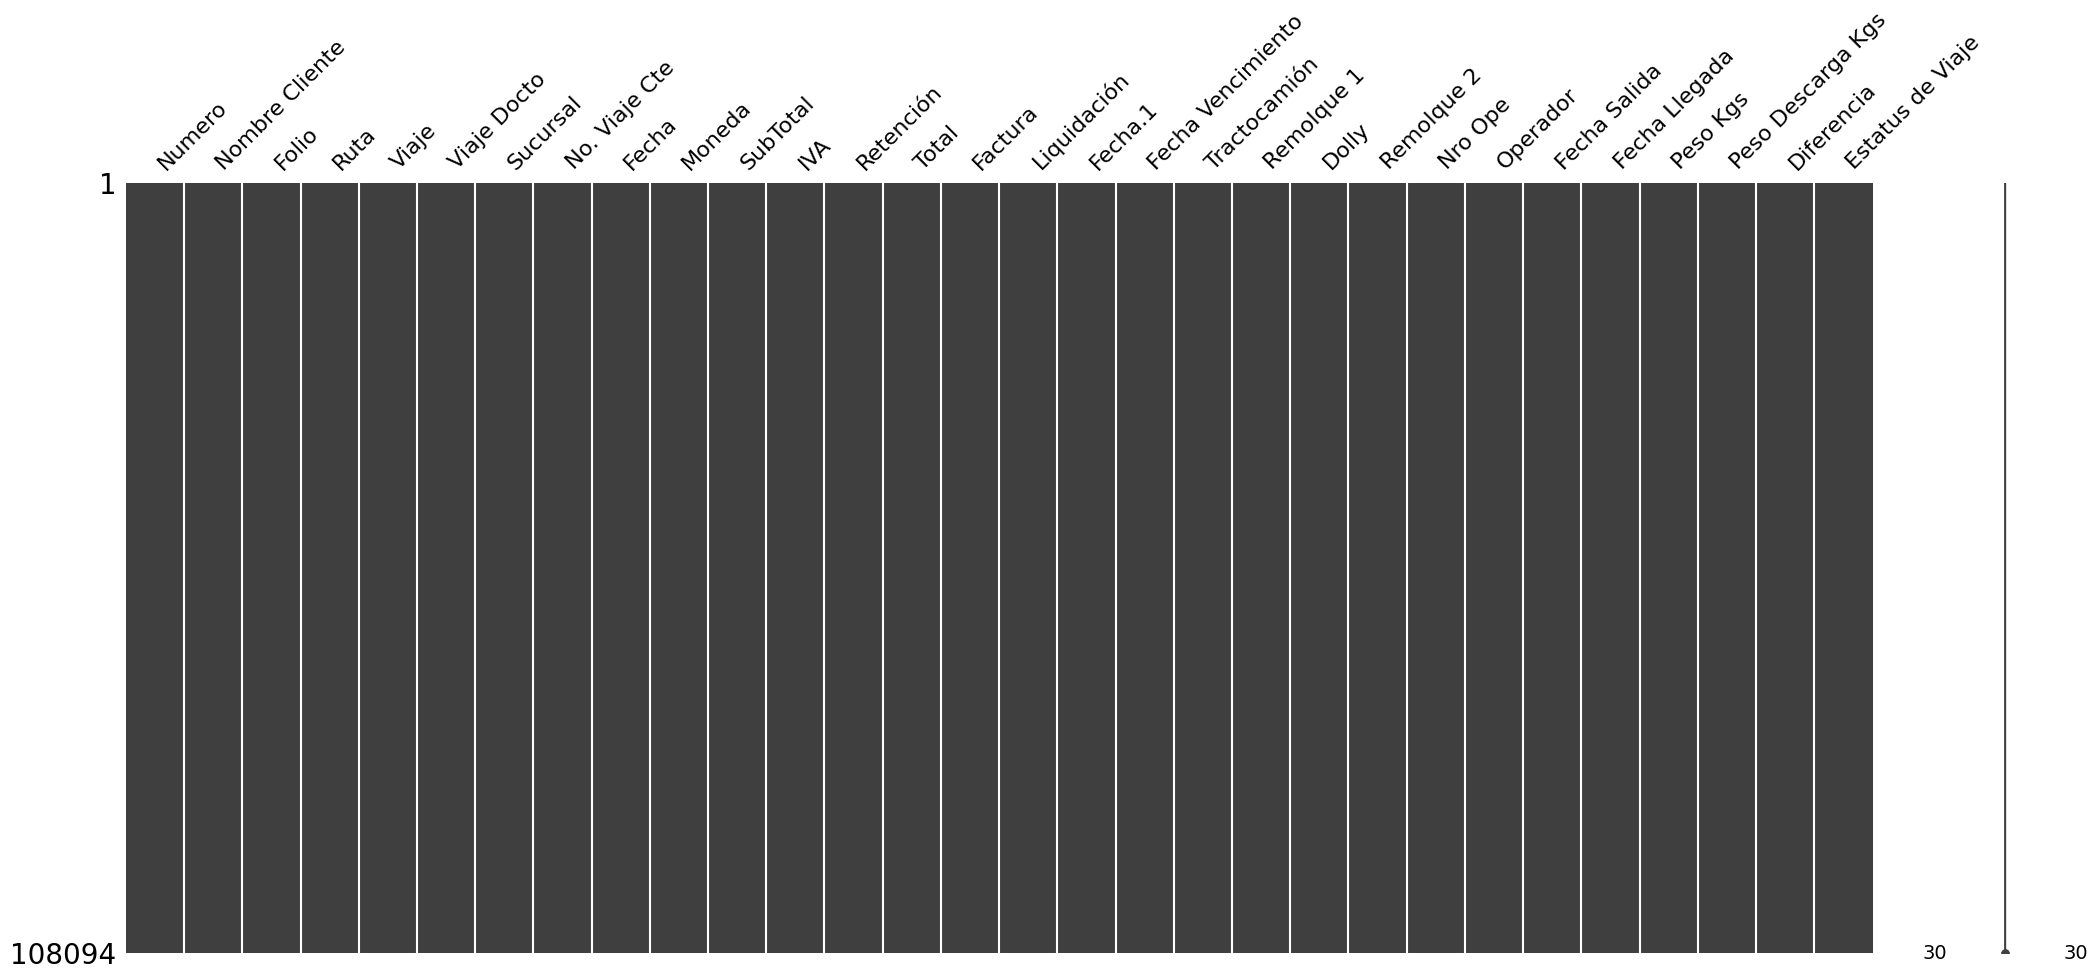

In [10]:
msno.matrix(viajes)
#Reporte sin nulos

Pudimos identificar los siguientes hallazgos:

In [11]:
viajes_vacio = viajes[(viajes['Total'] == 0) & (viajes['Peso Kgs'] == "0" )]
viajes_vacio.shape[0]

16639

Alrededor de 16,639 de viajes vacíos, los que determinamos como aquellos viajes en donde el Importe Total fuera 0 y aparte tuviera 0kgs en Peso transportado

In [12]:
unidades_totales = viajes['Tractocamión'].unique()
len(unidades_totales)

348

Tomando solamente las unidades únicas en la columnas de Tractocamión, pudimos determinar que hay 348 tractocamiones

In [13]:
viajes['Fecha Salida'] = pd.to_datetime(viajes['Fecha Salida'], errors='coerce')
viajes['Fecha Llegada'] = pd.to_datetime(viajes['Fecha Llegada'], errors='coerce')

# Calculate lead time as Timedelta
viajes['lead_time_timedelta'] = viajes['Fecha Llegada'] - viajes['Fecha Salida']

# Convert timedelta to hours, handling NaT values
# Only consider positive durations as lead time cannot be negative
viajes['lead_time_horas'] = viajes['lead_time_timedelta']
viajes.loc[viajes['lead_time_horas'] < '0 days 00:00:00', 'lead_time_horas'] = pd.NA

# Display 'Ruta' and the calculated 'lead_time_horas'
viajes[['Ruta', 'lead_time_horas']].sort_values(by='lead_time_horas', ascending=False)

,Ruta,lead_time_horas
27803,SAMS CLUB MERIDA ORIENTE/WM CEDIS PERECEDERO VHSA,39447 days 00:11:00
28926,CEDIS WM MEGAPARK/CEDIS WM CHALCO,32873 days 02:49:00
22812,BB PACABTUN/BB CENTRO,8373 days 00:26:00
8241,WM CEDIS CHALCO/ WM CEDIS MEGAPARK,7670 days 15:17:00
62348,TULUM/BB PLAYA DEL CARMEN,7305 days 03:00:00
...,...,...
103950,WM CEDIS MID TEYA/WM CANCUN POLIGONO SUR,NaT
107565,CEDIS FRIALSA GDL/CEDIS FRIALSA CULIACAN,NaT
108590,CEDIS WM MTY - LAREDO/CEDIS FRIALSA AGS,NaT
108797,CEDIS WM MTY - LAREDO/CEDIS FRIALSA CULIACAN,NaT


Una duración por cada ruta y viaje

In [14]:
viajes['Peso Kgs'] = pd.to_numeric(viajes['Peso Kgs'], errors='coerce')
peso_acumulado_por_ruta = viajes.groupby('Ruta')['Peso Kgs'].sum().reset_index()
peso_acumulado_por_ruta = peso_acumulado_por_ruta.sort_values(by='Peso Kgs', ascending=False)
print("Peso acumulado por Ruta (en Kgs):")
print(peso_acumulado_por_ruta)

Peso acumulado por Ruta (en Kgs):
                                                   Ruta      Peso Kgs
2096            WM BODEGA REMOTA CHALCO/WM CEDIS CHALCO  3.103693e+08
994                   CEDIS WM MEGAPARK/CEDIS WM CHALCO  5.394478e+07
2340             WM CEDIS MEGAPARK/WM CEDIS GUADALAJARA  4.972065e+07
2344               WM CEDIS MEGAPARK/WM CEDIS MONTERREY  4.853804e+07
2341                  WM CEDIS MEGAPARK/WM CEDIS LA LUZ  3.667968e+07
...                                                 ...           ...
1010              CERVECERIA YUCATECA/CEDIS OXXO CANCUN  0.000000e+00
1009                CERVECERIA YUCATECA/7 ELEVEN CANCUN  0.000000e+00
1008  CENTRO DE DISTRIBUCIÓN UNILEVER/WM CEDIS VILLA...  0.000000e+00
1007  CEDIS WM VILLAHERMOSA PERECEDEROS/SUPER CENTER...  0.000000e+00
2687                  |WM CEDIS CHALCO/BODEGA HUAJUAPAN  0.000000e+00

[2688 rows x 2 columns]


Rutas con mayor peso

In [15]:
# Eliminamos valores de fecha de salida y llegada que no correspondan al 2025
viajes = viajes[viajes['Fecha Salida'].dt.year == 2025]
viajes = viajes[viajes['Fecha Llegada'].dt.year == 2025]

In [16]:
# Guardamos el dataset limpio en un nuevo archivo csv
viajes.to_csv('Viajes_limpio.csv', index=False)

##Fallas

In [17]:
fallas = pd.read_excel('Reporte de fallas.xlsx', header=1)
fallas.head()

,Folio,Fecha de reporte de falla,Unidad,Descripción de Unidad,Tipo de unidad,Nombre del operador,Orden de servicio,Clasificación de servicio,Descripción,Estatus,Fecha de Estatus,Sucursal
0,118288887,2025-08-18,TP454,REMOLQUE LONAS 2 EJES,REFRESQUERO,LLANES CHUC LUIS ANGEL,9822.0,LLANTAS,CAMBIO DE UNA LLANTA 24.5,ATENDIDO,18/08/2025 19:08:36,MERIDA/YUC001
1,118289071,2025-08-21,TP454,REMOLQUE LONAS 2 EJES,REFRESQUERO,FLOTA CENTENO CRISTOBAL JAIR,10006.0,CORRECTIVO,POR FUGA DE CILINDROS EN TECHO Y FUGAS DE AIRE,ATENDIDO,21/08/2025 18:46:37,MERIDA/YUC001
2,118291250,2025-10-14,TP454,REMOLQUE LONAS 2 EJES,REFRESQUERO,CHAN HUCHIM MIGUEL ANGEL,12178.0,CORRECTIVO,"REPARACION DE LONAS , CILINDROS DE TECHO ,",ATENDIDO,16/10/2025 22:22:14,MERIDA/YUC001
3,118291369,2025-10-19,TP454,REMOLQUE LONAS 2 EJES,REFRESQUERO,PACHECO DORANTES MEDARDO,12292.0,CORRECTIVO,REPARAR CHASIS FISURADO,ATENDIDO,21/10/2025 19:20:47,MERIDA/YUC001
4,118289286,2025-08-25,C74,AMAROK,PICKUP,RODRIGUEZ MADRIGAL ERICK OMAR,10220.0,GENERAL,"CAMBIO DE POSTENFRIADOR DE ESCAPE, SUMINISTRAD...",ATENDIDO,25/08/2025 17:01:07,CARDENASCG/TAB004


In [18]:
# Eliminamos filas totalmente vacías
fallas = fallas.dropna(how = "all").reset_index(drop = True)

# Eliminamos, basandonos en la columna Estatus, todas las que digan PENDIENTE
fallas = fallas[fallas['Estatus'] != 'PENDIENTE']


fallas['Fecha de Estatus'] = pd.to_datetime(fallas['Fecha de Estatus'], errors = 'coerce', dayfirst = True)


In [19]:
# Eliminamos todas las unidades diferentes de 'T'

# Aseguramos que Unidad es string
fallas['Unidad'] = fallas['Unidad'].astype(str)

# Filtrar únicamente las unidades que comienzan con T seguido de números
fallas = fallas[fallas['Unidad'].str.match(r'^T\d+$', na=False)].copy().reset_index(drop = True)

fallas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Folio                      1887 non-null   int64         
 1   Fecha de reporte de falla  1887 non-null   datetime64[ns]
 2   Unidad                     1887 non-null   object        
 3   Descripción de Unidad      1887 non-null   object        
 4   Tipo de unidad             1887 non-null   object        
 5   Nombre del operador        1623 non-null   object        
 6   Orden de servicio          1887 non-null   float64       
 7   Clasificación de servicio  1881 non-null   object        
 8   Descripción                1887 non-null   object        
 9   Estatus                    1887 non-null   object        
 10  Fecha de Estatus           1874 non-null   datetime64[ns]
 11  Sucursal                   1887 non-null   object        
dtypes: dat

In [20]:
# Sacamos los meses que hay en el DF
fallas['Mes'] = fallas['Fecha de reporte de falla'].dt.month

# Eliminamos las entradas de Noviembre
fallas_filtrado = fallas[fallas['Mes'] != 11].copy().reset_index(drop = True)

# Sacamos las unidades totales que hay en el DF
unidades_totales = fallas_filtrado['Unidad'].nunique()
unidades_totales

304

In [21]:
fallas_copia = fallas.copy()

# Hacemos un conteo de ordenes de trabajo por unidad
servicios_por_unidad = (
    fallas_copia.groupby('Unidad')['Orden de servicio']
    .count()
    .reset_index()
    .sort_values('Orden de servicio', ascending = False)
    )
servicios_por_unidad

,Unidad,Orden de servicio
89,T535,23
20,T444,23
41,T470,22
153,T614,21
129,T582,20
...,...,...
281,T785,1
26,T452,1
235,T735,1
25,T451,1


###Cantidad de servicios por la sucursal

In [22]:
# Hacemos un conteo de ordenes de trabajo por sucursal
servicios_por_sucursal = (fallas_copia.groupby('Sucursal')['Orden de servicio']
    .count()
    .reset_index()
    .sort_values('Orden de servicio', ascending = False)
    )
servicios_por_sucursal

,Sucursal,Orden de servicio
2,MERIDA/YUC001,678
0,CARDENASCG/TAB004,391
3,MEXICO/EMX003,333
5,QUERETARO/QRO003,254
4,QROO/QUI001,124
1,CHALCO/CMX001,107


###Conteo de la cantidad de servicios que entraron con orden de servicio vs la cantidad de unidades atendidas en la misma sucursal.

In [23]:
# Hacemos un listado de unidades en el dfg sin valores repetidos.
unidades = fallas_copia['Unidad'].unique()

# Hacemos un conteo de ordenes de trabajo por sucursal VS la cantidad de unidades que hay en la sucursal
servicios_por_sucursal_vs_unidades = (fallas_copia.groupby('Sucursal')[['Orden de servicio', 'Unidad']].nunique()
    .reset_index()
    .sort_values('Orden de servicio', ascending = False)
    )
servicios_por_sucursal_vs_unidades

,Sucursal,Orden de servicio,Unidad
2,MERIDA/YUC001,664,149
0,CARDENASCG/TAB004,391,45
3,MEXICO/EMX003,331,79
5,QUERETARO/QRO003,253,61
4,QROO/QUI001,124,36
1,CHALCO/CMX001,106,52


###Tiempo que se tarda en atender una solicitud

In [24]:
# Hacemos una columan en la que estén los tiempos que se tardan en atender las solicitudes
fallas_copia['Tiempo_de_atencion'] = fallas_copia['Fecha de Estatus'] - fallas_copia['Fecha de reporte de falla']
fallas_copia['Tiempo_de_atencion'] = fallas_copia['Tiempo_de_atencion'].dt.days
fallas_copia['Tiempo_de_atencion'].describe()

count    1874.000000
mean        1.694771
std         6.159276
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        71.000000
Name: Tiempo_de_atencion, dtype: float64

In [25]:
# Obtenemos todos los tiempos que son diferentes de cero
dif_de_cero = fallas_copia['Tiempo_de_atencion'][fallas_copia['Tiempo_de_atencion'] != 0]
dif_de_cero.describe()

count    380.000000
mean       8.357895
std       11.473651
min        1.000000
25%        1.000000
50%        3.000000
75%       10.000000
max       71.000000
Name: Tiempo_de_atencion, dtype: float64

In [26]:
# Extraemos el mes como número o nombre
fallas_copia['Mes'] = fallas_copia['Fecha de reporte de falla'].dt.month
fallas_copia['Mes'] = fallas_copia['Fecha de reporte de falla'].dt.month


###Porcentaje de tractos con falla por mes

In [27]:
pr_por_mes = {}

for mes in sorted(fallas_copia['Mes'].dropna().unique()):
  fallas_copia_mes = fallas_copia[fallas_copia['Mes'] == mes]

  unique_fallas_copia_mes = set(fallas_copia_mes['Unidad'].unique())

  pr_fallas_por_mes = len(unique_fallas_copia_mes) / unidades_totales

  # Los guardamos en un diccionario

  pr_por_mes[mes] = {
      'unidades_atendidas en el mes': len(unique_fallas_copia_mes),
      'porcentaje_de_fallas': pr_fallas_por_mes,
      }
# convertimos el diccionario en DF
fallas_copia_mes = pd.DataFrame.from_dict(pr_por_mes, orient='index')
fallas_copia_mes

,unidades_atendidas en el mes,porcentaje_de_fallas
8,241,0.792763
9,222,0.730263
10,219,0.720395
11,31,0.101974


In [28]:
# Guadamos el dataset limpio en un nuevo archivo csv
fallas_filtrado.to_csv('Fallas_limpio.csv', index=False)

#2. Implementación de modelos seleccionados

La pregunta que modelaremos en este entrega serán los lead times, con el modelo XGBoost

#3. Entrenamiento y Evaluación

In [29]:
sns.set(style="whitegrid", font_scale=1.1)

## Preparación de datos

In [30]:
viajes_modelo = viajes.copy()
viajes_modelo = viajes_modelo[viajes_modelo['lead_time_horas'].notna()].copy()

# Timedelta a horas
viajes_modelo['lead_time_hours'] = viajes_modelo['lead_time_horas'] / np.timedelta64(1, 'h')

# Acotamos 'lead_time_hours' a un máximo de 720
viajes_modelo.loc[viajes_modelo['lead_time_hours'] > 720, 'lead_time_hours'] = 720

viajes_modelo = viajes_modelo[viajes_modelo['lead_time_hours'] >= 0].copy()
y = viajes_modelo['lead_time_hours']

numeric_features = [
    'SubTotal',
    'IVA',
    'Retención',
    'Total',
    'Peso Kgs',
    'Peso Descarga Kgs',
    'Diferencia'
    ]

categorical_features = [
    'Sucursal',
    'Ruta',
    'Tractocamión',
    'Remolque 1',
    'Dolly',
    'Remolque 2',
    'Operador',
    'Moneda',
    'Estatus de Viaje'
    ]

X = viajes_modelo[numeric_features + categorical_features].copy()

# División entrenamiento / validación (80 / 20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)

## Transformaciones: normalización + one-hot

In [31]:
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
     ('scaler', StandardScaler())
     ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str))),
     ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
     ])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

## Modelo base de XGBoost

In [32]:
xgb_base = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 42,
    n_jobs = -1
    )

# Pipeline completo: preprocesamiento + modelo
xgb_pipeline = Pipeline(steps = [
    ('preprocess', preprocess),
     ('model', xgb_base)
     ])

## Ajuste de hiperparámetros (RandomizedSearchCV)

In [33]:
param_distributions = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5, 6, 8],
    'model__learning_rate': [0.003, 0.005, 0.007, 0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__min_child_weight': [1, 5, 10]
    }

random_search = RandomizedSearchCV(
    estimator = xgb_pipeline,
    param_distributions=param_distributions,
    n_iter = 20,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 1,
    random_state = 42,
    n_jobs = -1
)

random_search.fit(X_train, y_train)

print('Mejores hiperparámetros encontrados:')
print(random_search.best_params_)

best_model = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados:
{'model__subsample': 0.8, 'model__n_estimators': 300, 'model__min_child_weight': 10, 'model__max_depth': 5, 'model__learning_rate': 0.007, 'model__colsample_bytree': 0.8}


In [34]:
random_search_2 = RandomizedSearchCV(
    estimator = xgb_pipeline,
    param_distributions=param_distributions,
    n_iter = 20,
    scoring = 'r2',
    cv = 3,
    verbose = 1,
    random_state = 42,
    n_jobs = -1
)

random_search_2.fit(X_train, y_train)

print('Mejores hiperparámetros encontrados:')
print(random_search_2.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados:
{'model__subsample': 0.8, 'model__n_estimators': 300, 'model__min_child_weight': 10, 'model__max_depth': 5, 'model__learning_rate': 0.007, 'model__colsample_bytree': 0.8}


##Evaluación en el conjunto de validación

In [35]:
# Predicciones
y_val_pred = best_model.predict(X_val)

# RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# R²
r2 = r2_score(y_val, y_val_pred)

# R² ajustada
n = len(y_val)
# Número de features después de one-hot:
k = best_model.named_steps['model'].n_features_in_
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(f'\nResultados en el conjunto de validación:')
print(f'RMSE: {rmse:.4f} horas')
print(f'R²: {r2:.4f}')
print(f'R² ajustada: {adj_r2:.4f}')

# Guardamos resultados en un DataFrame para análisis por sucursal
val_results = X_val.copy()
val_results['lead_time_real'] = y_val
val_results['lead_time_pred'] = y_val_pred


Resultados en el conjunto de validación:
RMSE: 35.0749 horas
R²: 0.0670
R² ajustada: -0.6626


In [36]:
best_model2 = random_search_2.best_estimator_

# Predicciones
y_val_pred_2 = best_model2.predict(X_val)

# RMSE
rmse_2 = np.sqrt(mean_squared_error(y_val, y_val_pred_2))

# R²
r2_2 = r2_score(y_val, y_val_pred_2)

# R² ajustada
n = len(y_val)
# Número de features después de one-hot:
k = best_model2.named_steps['model'].n_features_in_
adj_r2_2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(f'\nResultados en el conjunto de validación:')
print(f'RMSE: {rmse:.4f} horas')
print(f'R²: {r2_2:.4f}')
print(f'R² ajustada: {adj_r2_2:.4f}')

# Guardamos resultados en un DataFrame para análisis por sucursal
val_results_2 = X_val.copy()
val_results_2['lead_time_real'] = y_val
val_results_2['lead_time_pred'] = y_val_pred_2


Resultados en el conjunto de validación:
RMSE: 35.0749 horas
R²: 0.0670
R² ajustada: -0.6626


##Gráfico de serie temporal: predicción vs real (por sucursal)

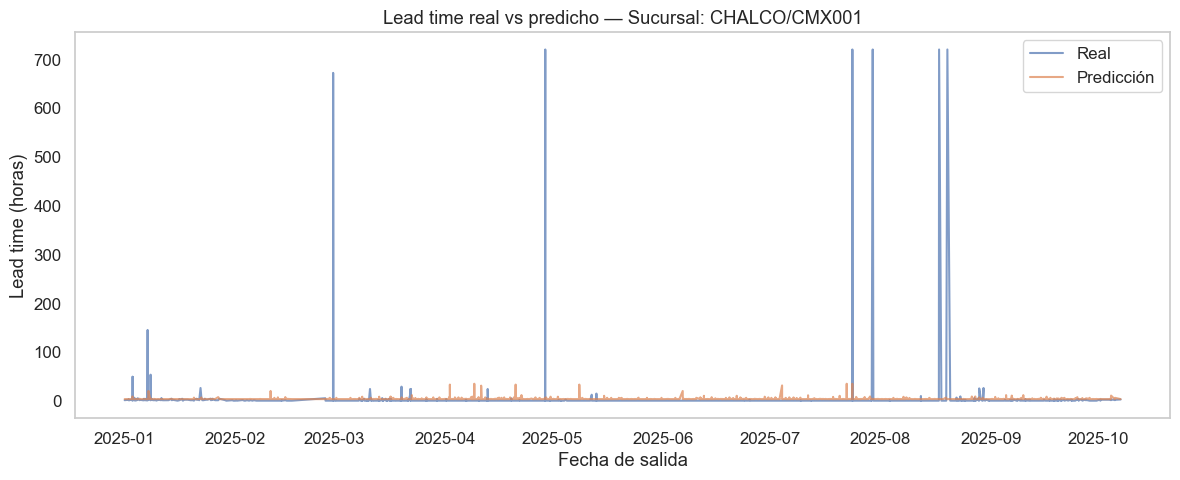

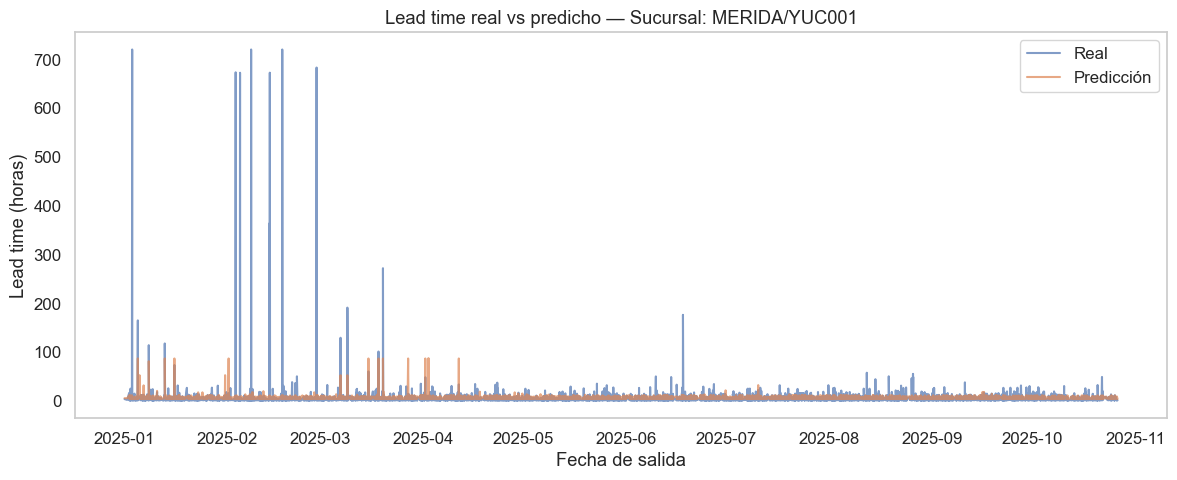

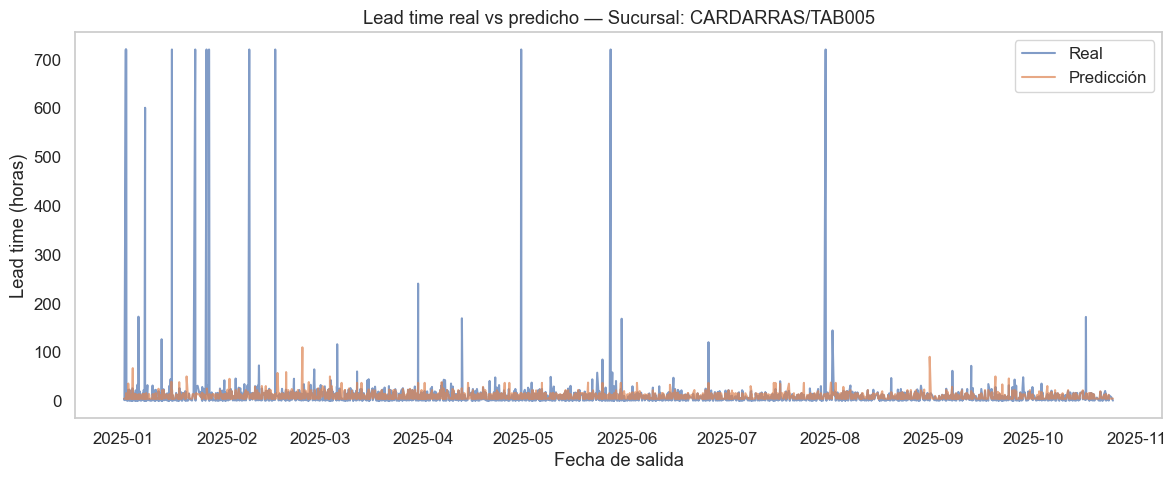

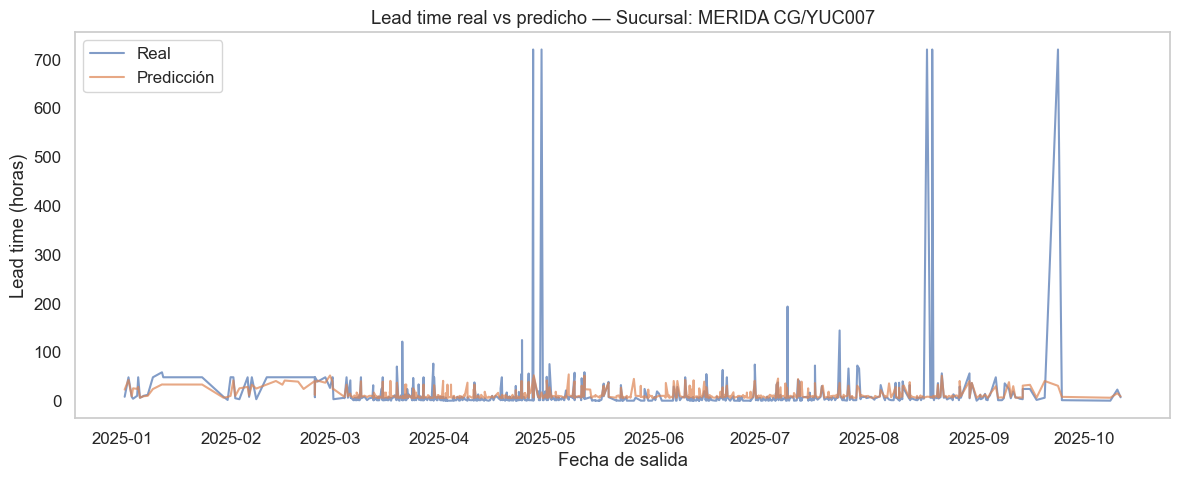

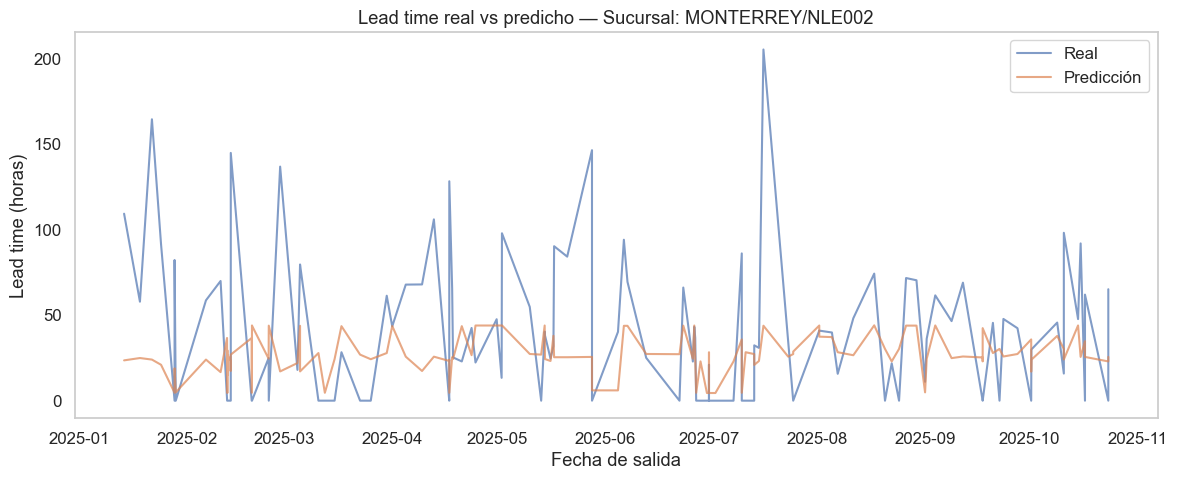

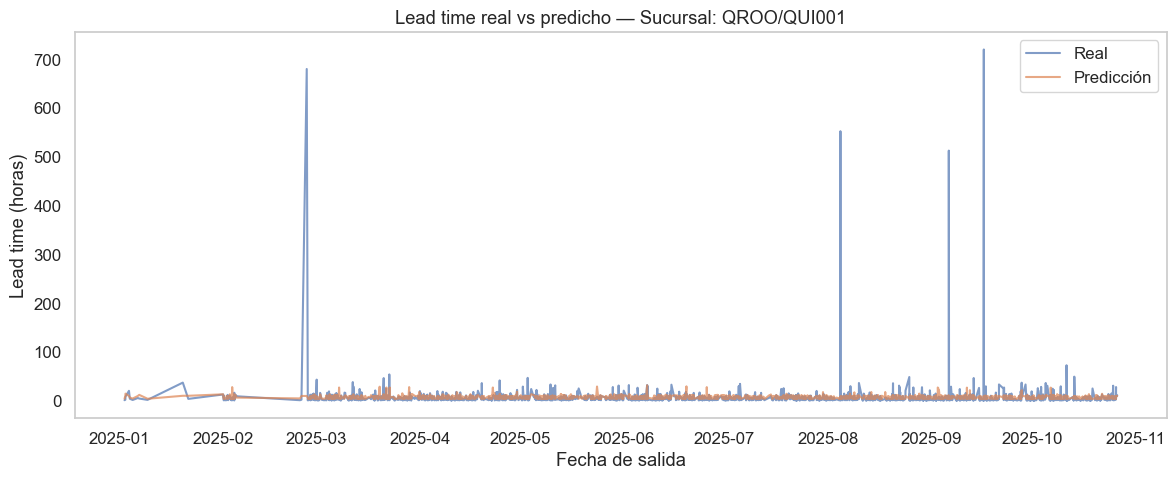

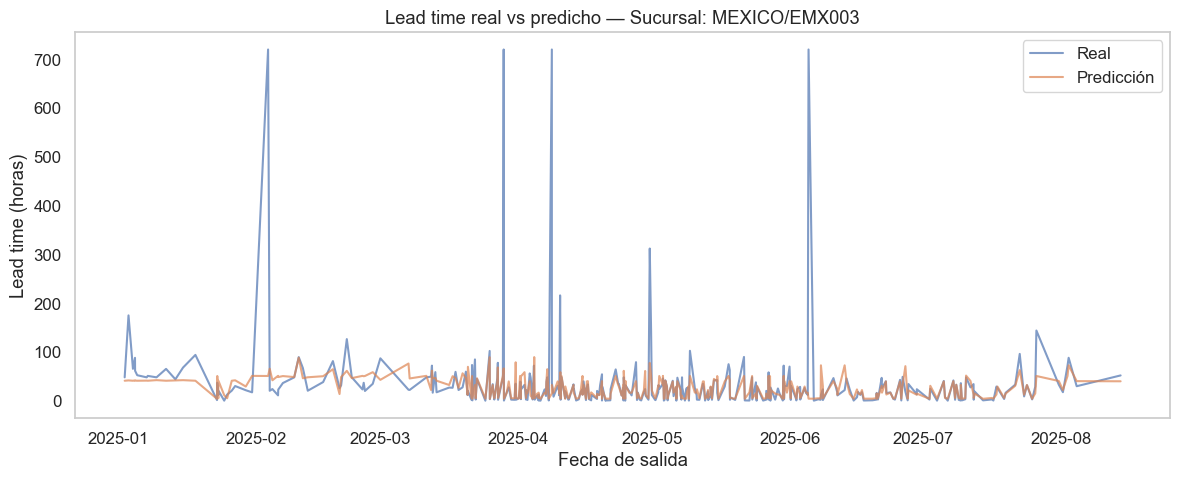

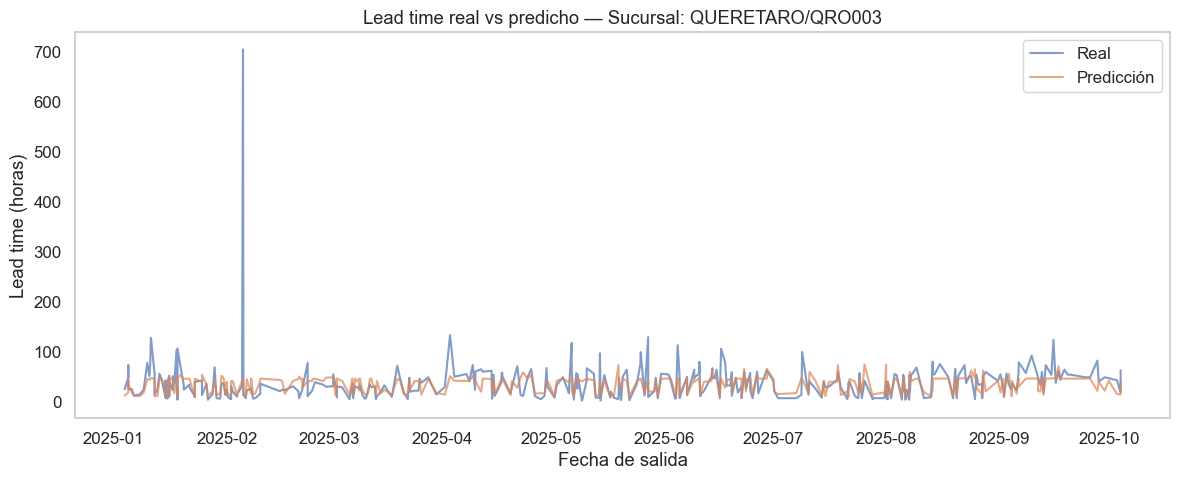

In [37]:
# Fechas para el conjunto de validación
val_results = val_results.join(
    viajes_modelo[['Fecha Salida']].loc[y_val.index]
)

# Gráfica para cada sucursal
sucursales_criticas = val_results['Sucursal'].unique()

for suc in sucursales_criticas:
    df_suc = val_results[val_results['Sucursal'] == suc].copy()
    df_suc = df_suc.sort_values('Fecha Salida')

    if df_suc.empty:
        continue

    plt.figure(figsize=(12,5))
    plt.plot(df_suc['Fecha Salida'], df_suc['lead_time_real'], label = 'Real', alpha = 0.7)
    plt.plot(df_suc['Fecha Salida'], df_suc['lead_time_pred'], label = 'Predicción', alpha = 0.7)
    plt.title(f'Lead time real vs predicho — Sucursal: {suc}')
    plt.xlabel('Fecha de salida')
    plt.ylabel('Lead time (horas)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Mapa de calor de correlaciones entre variables

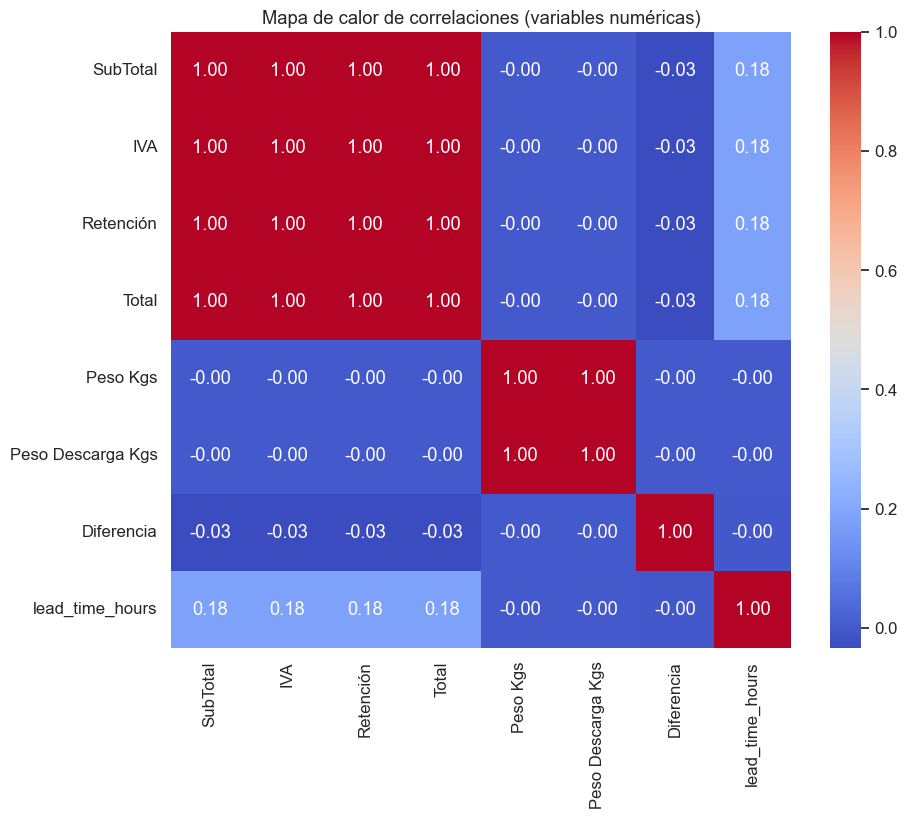

In [38]:
corr_df = viajes_modelo[numeric_features + ["lead_time_hours"]].copy()
corr = corr_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones (variables numéricas)")
plt.show()